In [1]:
import sys
import time
import datetime
import os
import tensorflow as tf
import argparse
import json
import socket
from PIL import Image
from util import *
import numpy as np
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib.colors import hsv_to_rgb
from helpers import *

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
logPath = "TRAINING/training/"
snapshotPath = "SNAPSHOTS/snapshots/"

In [3]:
with open("hyperParams.json") as f:
    instanceParams = json.load(f)

instanceParams

{u'baseLR': 1e-05,
 u'batchSize': 2,
 u'borderThicknessH': 0.02,
 u'borderThicknessW': 0.02,
 u'boundaryAlpha': 6.5,
 u'dataset': u'kitti2012',
 u'flowScale': 255.0,
 u'gradParams': {u'robustness': 0.46, u'scale': 255.0, u'weight': 6.408},
 u'instanceName': u'unsupFlownet',
 u'iterations': 500000,
 u'lossComponents': {u'asymmetricSmooth': True,
  u'backward': True,
  u'boundaries': False,
  u'gradient': False,
  u'smooth2nd': False},
 u'photoParams': {u'robustness': 1.0, u'scale': 255.0},
 u'printFreq': 1000,
 u'resnet': False,
 u'smooth2ndParams': {u'robustness': 0.21, u'scale': 1.0, u'weight': 0.53},
 u'smoothOccParams': {u'robustness': 0.9, u'scale': 1.8},
 u'smoothParams': {u'robustness': 1.0, u'scale': 1.0, u'weight': 10000.0},
 u'snapFreq': 5000,
 u'snapshotFreq': 20000,
 u'weightDecay': 0.0}

In [4]:
printFrequency = instanceParams["printFreq"]
batchSize = instanceParams["batchSize"]

iterations = instanceParams["iterations"]
baseLearningRate = instanceParams["baseLR"]
learningRate = baseLearningRate
snapshotFrequency = instanceParams["snapshotFreq"]

from dotmap import DotMap
arg = DotMap()
arg.logDev = False
arg.resume = 'n'
resume, startIteration, snapshotFiles = checkResume(snapshotPath,logPath, arg)

resuming from iteration 501000


### Training

In [5]:
with tf.device("/gpu:0"):
    trainingData = TrainingData(batchSize,instanceParams)

with tf.device("/gpu:0"):
    # init
    with tf.variable_scope("netShare"):
        networkBodyF = NetworkBody(trainingData,instanceParams)
    with tf.variable_scope("netShare",reuse=True):
        networkBodyB = NetworkBody(trainingData,instanceParams,flipInput=True)

    trainingLoss = TrainingLoss(instanceParams,networkBodyF,networkBodyB,trainingData)
    solver, solver_op, learningRateTensor = attachSolver(trainingLoss.loss)
    flowFinal = networkBodyF.flows[0]
    # loss scheduling
    recLossBWeightTensor = trainingLoss.recLossBWeight

Reading Tensor("ImagePairData/image_data_reader/Placeholder:0", dtype=string, device=/device:GPU:0)
Reading Tensor("ImagePairData/image_data_reader_1/Placeholder:0", dtype=string, device=/device:GPU:0)
Reading Tensor("ImagePairData/image_data_reader_2/Placeholder:0", dtype=string, device=/device:GPU:0)
Reading Tensor("ImagePairData/image_data_reader_3/Placeholder:0", dtype=string, device=/device:GPU:0)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
INFO:tensorflow:Summary name Network Output Smoothness is illegal; using Network_Output_Smoothness instead.
INFO:tensorflow:Summary name Network Output Smoothness is illegal; using Network_Output_Smoothness instead.
INFO:tensorflow:Summary name Network Output Smoothness is illegal; using Network_Output_Smoothness instead.
INFO:tensorflow:Summary name fhat Smoothness is illegal; using fhat_Smoothness instead.


In [6]:
# merge summaries
merged = tf.summary.merge_all()
# saver
saver = tf.train.Saver(max_to_keep=0)

In [7]:
printFrequency = 10
snapshotFrequency = 1000
iterations = 2020
startIteration = 0
print(printFrequency)
print(snapshotFrequency)
print(iterations)
print(startIteration)

10
1000
2020
0


In [8]:
flows = []
with sessionSetup(arg) as sess:
    saver.restore(sess,
                  '../model_download_scripts/photometric_smoothness/weights/iter_0000000000500000.ckpt')

    trainingData.dataQueuer.start_queueing(sess)

    #start summary writer
    summary_writer = tf.summary.FileWriter(logPath, sess.graph)

    #run
    lastPrint = time.time()
    for i in range(startIteration, startIteration + iterations + 10):
        # scheduled values
        learningRate = learningRateSchedule(baseLearningRate, i)
        recLossBWeight = unsupLossBSchedule(i)

         #run training
        feed_dict = {
            learningRateTensor: learningRate
        }
        summary,result,totalLoss = sess.run([merged,solver_op,trainingLoss.loss], feed_dict=feed_dict)

        if (i+1) % printFrequency == 0:
            timeDiff = time.time() - lastPrint
            itPerSec = printFrequency/timeDiff
            remainingIt = startIteration + iterations + 10 - i
            eta = remainingIt/itPerSec
            print("Iteration "+str(i+1)+": loss: "+str(totalLoss)+", iterations per second: "+str(itPerSec)+", ETA: "+str(datetime.timedelta(seconds=eta)))+", lr: "+str(learningRate)

            summary_writer.add_summary(summary,i+1)
            summary_writer.flush()
            lastPrint = time.time()
#             flows.append(deepcopy(f_est))

        if (i+1) % snapshotFrequency == 0:
            saver.save(sess,"snapshots/iter_"+str(i+1).zfill(16)+".ckpt")

        sys.stdout.flush()

    trainingData.dataQueuer.close(sess)

INFO:tensorflow:Restoring parameters from ../model_download_scripts/photometric_smoothness/weights/iter_0000000000500000.ckpt
Iteration 10: loss: [[228.55496 228.77603]
 [228.55495 228.77602]], iterations per second: 0.632650878108, ETA: 0:53:14.494894, lr: 1e-05
Iteration 20: loss: [[239.30334 239.31805]
 [239.30334 239.31802]], iterations per second: 1.17394413562, ETA: 0:28:33.028703, lr: 1e-05
Iteration 30: loss: [[177.49173 177.40904]
 [177.49173 177.40903]], iterations per second: 1.19811720131, ETA: 0:27:50.120417, lr: 1e-05
Iteration 40: loss: [[211.44635 211.5005 ]
 [211.44632 211.50046]], iterations per second: 1.23572839362, ETA: 0:26:51.195478, lr: 1e-05
Iteration 50: loss: [[187.9512  188.00713]
 [187.95126 188.00717]], iterations per second: 1.20460156613, ETA: 0:27:24.527166, lr: 1e-05
Iteration 60: loss: [[177.76306 177.52954]
 [177.76308 177.52954]], iterations per second: 1.18521891037, ETA: 0:27:42.983929, lr: 1e-05
Iteration 70: loss: [[179.08646 178.9419 ]
 [179.08

Iteration 600: loss: [[141.05232 141.07257]
 [141.05234 141.07257]], iterations per second: 1.14659975937, ETA: 0:20:48.037939, lr: 1e-05
Iteration 610: loss: [[140.50903 140.28998]
 [140.509   140.28995]], iterations per second: 1.13780827242, ETA: 0:20:48.892309, lr: 1e-05
Iteration 620: loss: [[140.96231 140.8678 ]
 [140.96234 140.8678 ]], iterations per second: 1.13590617023, ETA: 0:20:42.180065, lr: 1e-05
Iteration 630: loss: [[140.63765 140.7395 ]
 [140.63763 140.73947]], iterations per second: 1.14254573046, ETA: 0:20:26.209125, lr: 1e-05
Iteration 640: loss: [[138.8706  139.19305]
 [138.87062 139.19307]], iterations per second: 1.1364619248, ETA: 0:20:23.974134, lr: 1e-05
Iteration 650: loss: [[138.1059  138.58882]
 [138.10593 138.58884]], iterations per second: 1.11423381535, ETA: 0:20:39.416701, lr: 1e-05
Iteration 660: loss: [[140.04836 140.56705]
 [140.04837 140.56708]], iterations per second: 1.12381586553, ETA: 0:20:19.950743, lr: 1e-05
Iteration 670: loss: [[139.96918 14

Iteration 1190: loss: [[123.10098  123.35007 ]
 [123.10096  123.350044]], iterations per second: 1.07505715729, ETA: 0:13:02.283988, lr: 1e-05
Iteration 1200: loss: [[126.10092 125.37847]
 [126.10091 125.37846]], iterations per second: 1.09740644405, ETA: 0:12:37.239949, lr: 1e-05
Iteration 1210: loss: [[124.61509 124.13899]
 [124.6151  124.13898]], iterations per second: 1.10814277424, ETA: 0:12:20.879261, lr: 1e-05
Iteration 1220: loss: [[122.86105  122.305275]
 [122.86104  122.305244]], iterations per second: 1.13244318519, ETA: 0:11:56.150718, lr: 1e-05
Iteration 1230: loss: [[122.09554  121.75073 ]
 [122.09555  121.750725]], iterations per second: 1.09644494997, ETA: 0:12:10.542833, lr: 1e-05
Iteration 1240: loss: [[124.71991 123.97507]
 [124.71991 123.97505]], iterations per second: 1.12233357393, ETA: 0:11:44.781554, lr: 1e-05
Iteration 1250: loss: [[121.726074 121.73181 ]
 [121.72609  121.73183 ]], iterations per second: 1.13102735709, ETA: 0:11:30.522643, lr: 1e-05
Iteration 1

Iteration 1770: loss: [[113.49674 113.26432]
 [113.49678 113.26436]], iterations per second: 1.08739113331, ETA: 0:04:00.024028, lr: 1e-05
Iteration 1780: loss: [[112.03491  111.818115]
 [112.03491  111.818115]], iterations per second: 1.03712471708, ETA: 0:04:02.015252, lr: 1e-05
Iteration 1790: loss: [[115.352295 114.5995  ]
 [115.35231  114.59949 ]], iterations per second: 1.09914920121, ETA: 0:03:39.260497, lr: 1e-05
Iteration 1800: loss: [[113.1409   112.67769 ]
 [113.140884 112.67769 ]], iterations per second: 1.0992573134, ETA: 0:03:30.141881, lr: 1e-05
Iteration 1810: loss: [[110.81703 110.89393]
 [110.81703 110.89394]], iterations per second: 1.11073594932, ETA: 0:03:18.967180, lr: 1e-05
Iteration 1820: loss: [[110.51224 110.52843]
 [110.51226 110.52844]], iterations per second: 1.10367603262, ETA: 0:03:11.179290, lr: 1e-05
Iteration 1830: loss: [[113.96052 113.41316]
 [113.96054 113.41318]], iterations per second: 1.10725258064, ETA: 0:03:01.530397, lr: 1e-05
Iteration 1840: 

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/y788zhang/.conda/envs/p27/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/y788zhang/.conda/envs/p27/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "util/data_input/DataQueuer.py", line 88, in thread_main
    exit()
NameError: global name 'exit' is not defined

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/y788zhang/.conda/envs/p27/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/y788zhang/.conda/envs/p27/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "util/data_input/DataQueuer.py", line 88, in thread_main
    exit()
NameError: global name 'exit' is not defined
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/y788zhang/.conda/envs/p27/lib/python2.7/threading.

### Testing

In [5]:
datasetRoot = '../example_data/'
frame0Path = '../example_data/datalists/train_im0.txt'
frame1Path = '../example_data/datalists/train_im1.txt'
gt0Path = '../example_data/datalists/train_gt0.txt'
desiredHeight = 480
desiredWidth = 854

In [6]:
with open(frame0Path) as f:
    imagePairs0 = [datasetRoot+x[:-1] for x in f.readlines()]
with open(frame1Path) as f:
    imagePairs1 = [datasetRoot+x[:-1] for x in f.readlines()]
with open(gt0Path) as f:
    gtPairs1 = [datasetRoot+x[:-1] for x in f.readlines()]

In [7]:
imagePairs0 = [item for item in imagePairs0 if 'bus' in item]
imagePairs1 = [item for item in imagePairs1 if 'bus' in item]
gtPairs1 = [item for item in gtPairs1 if 'bus' in item]

In [8]:
testData = TestData(imagePairs0,imagePairs1,gtPairs1,1,desiredHeight,desiredWidth)

In [9]:
with tf.device("/gpu:0"):
    with tf.variable_scope("netShare"):
        networkBody = NetworkBody(testData,instanceParams)
    flowFinal = networkBody.flows[0]

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [10]:
flowViz = flowToRgb(flowFinal)
transformGrid = flowTransformGrid(flowFinal)
mean = tf.expand_dims(tf.expand_dims(tf.expand_dims([0.407871, 0.457525, 0.481094], 0), 0), 0)

In [11]:
saver = tf.train.Saver()

# config tensorflow
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True

In [14]:
test_length = 70
start = 0
result_dir = 'results'
iterations = 515000

flows = []
viz = []
gradients = []
ground_truths = []
arrs = []
with tf.Session(config=config) as sess:
    saver.restore(sess,"snapshots/iter_0000000000002000.ckpt")

    # run
    lastPrint = time.time()
    for i in range(start, start + min(test_length, len(imagePairs0))):
        feed_dict = {
            testData.im0File: imagePairs0[i],
            testData.im1File: imagePairs1[i],
            testData.gt0File: gtPairs1[i]
        }
        hsv, f = sess.run([flowViz, flowFinal],feed_dict=feed_dict)

        flows.append(deepcopy(f))
        h, w = 448, 532
        arr = np.maximum(np.minimum(np.asarray(hsv),1), 0)
        arr = np.squeeze(np.asarray(arr*255,np.uint8))
        arrs.append(deepcopy(arr[:h,:w,:]))
        im = Image.fromarray(arr[:h,:w,:])
        viz.append(deepcopy(im))
        # im.save("{}/{}.png".format(result_dir, str(i).zfill(3)))

INFO:tensorflow:Restoring parameters from snapshots/iter_0000000000002000.ckpt


In [18]:
flows.shape

(70, 448, 832, 2)

In [19]:
flows = np.array(flows)
arrs = np.array(arrs)

max flow: 6.5333
flow range:
u = -6.239 .. 4.859
v = -3.278 .. 2.843


<IPython.core.display.Javascript object>


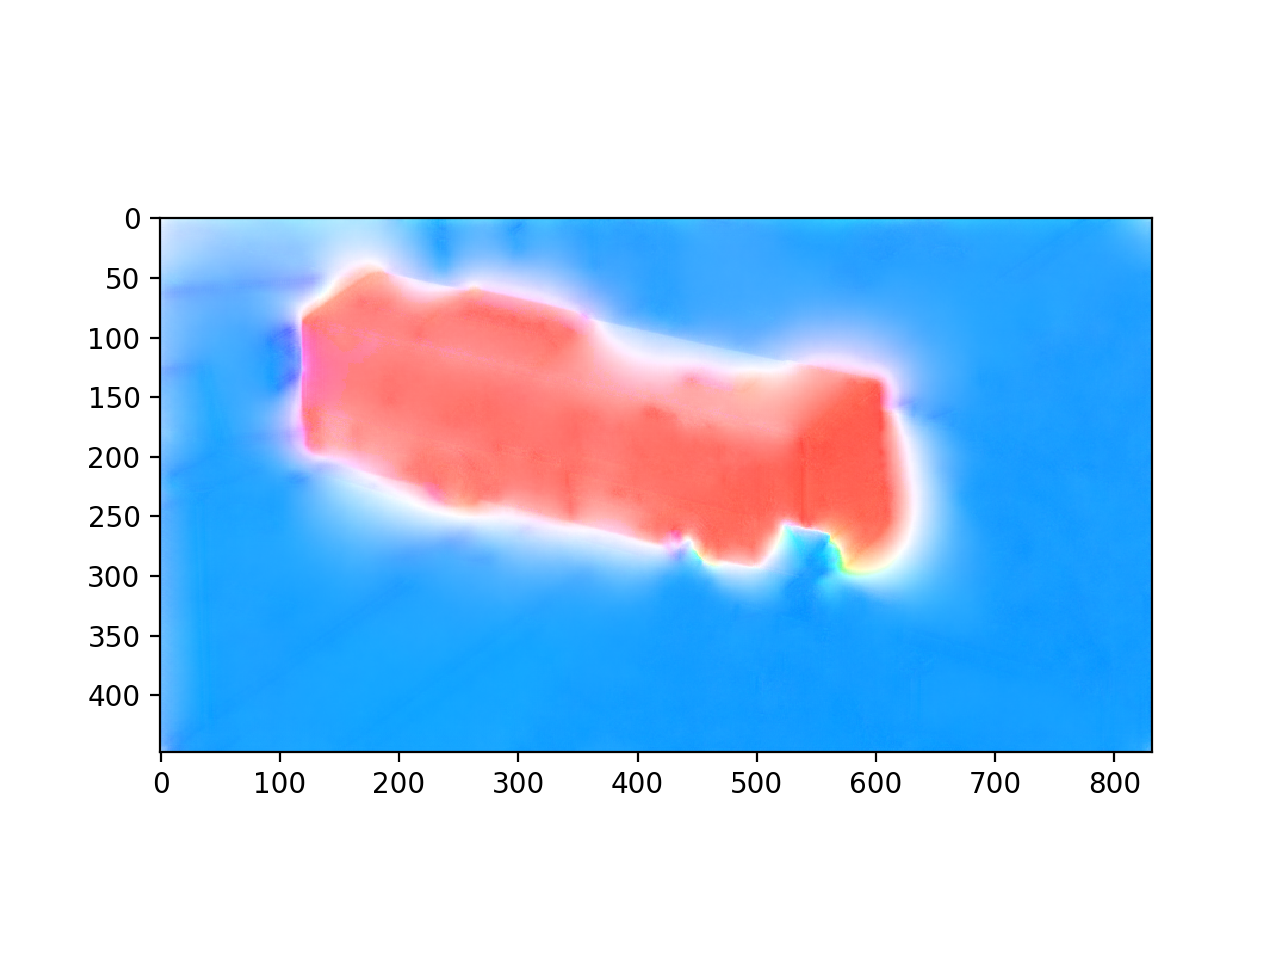

In [47]:
plt.imshow(flow_to_image(flows[23]))